# Stochastic Gradient Descent

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import math

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("w8a/w8a.csv", sep=";", header=None)


X=data.iloc[:,:-1].to_numpy()
y=data.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

## Logistic Regression



Today weâ€™ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [53]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.985320989158241

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [44]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
    """
    def __init__(self, lr = 1e-3, gamma=.9,beta=0.999, max_iter=100,lambd=0.1,
                 batch_size=1, eps=1e-10, debias=False):
        self.coef_  = None
        self.lambd_ = lambd
        self.lr_     = lr
        self.batch_size_  = batch_size
        self.coef_history_ = list()
        self.f_history_ = list()
        self.gamma_ = gamma
        self.beta_ = beta
        self.eps_ = eps
        self.debias_ = debias
        self.max_iter_ = max_iter

    def logistic(self, z):
        # logistic function
        return 1/(1 + np.exp(-z))
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """      
        n_samples, n_features = X.shape
        X_aug = np.ones((n_samples, n_features + 1))
        X_aug[:, 1:] = X
        
        #initializ
        start = np.random.normal(0.1,0.01,(1,n_features+1))
        theta_0, grad_0, m_0, s_0 = start, start, start, start
        
        self.coef_history_.append(theta_0)
        
        def compute_loss(theta):
            "compute the logisitic loss over all obseravtaions"
            loss = 0
            for i in range(n_samples):
                loss+= math.log(1 + math.exp(-y[i]*theta@(X_aug[i,:].T)))
            #loss+=0.5*self.lambd_*(theta @ theta.T)
            return loss
        
        def compute_grad(theta, batch_indices):
            "compute a minibatch gradient"
            grad = np.zeros((1,n_features+1))
            for ind in batch_indices:
                grad+= y[ind]*self.logistic(-y[ind]*theta@X_aug[ind,:].T)*X_aug[ind,:]
            grad = -1*grad + self.lambd_*theta
            grad = grad/len(batch_indices)
            return grad
                
            
            
        #iterate and update(theta_t, grad_t, m_t, s_t)
        theta_t, grad_t, m_t, s_t = theta_0, grad_0, m_0, s_0
        
        for t in range(self.max_iter_):
            #update theta
            theta_t = theta_t - self.lr_ * m_t/np.sqrt(s_t+self.eps_)
            
            self.coef_history_.append(theta_t)
            self.f_history_.append(compute_loss(theta_t))
            #update grad_t
            batch_indices = np.random.randint(n_samples, size = self.batch_size_)
            grad = compute_grad(theta_t, batch_indices)
            
            #update m_t
            m_t = self.beta_*m_t + (1-self.beta_)*grad
            if self.debias_:
                m_t = m_t /(1-self.beta_**t)
            
            #update s_t
            s_t = self.gamma_*s_t + (1-self.gamma_)*(grad*grad)
            if self.debias_:
                s_t = s_t/(1-self.gamma_**t)
        
        #record best teta after having iterated
        self.coef_ = theta_t
        
         
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        n_samples, n_features = X.shape
        X_aug = np.ones((n_samples, n_features + 1))
        X_aug[:, 1:] = X
        y_pred = X_aug @ self.coef_.T  #these are probabilities
        #We apply a threshold (>0.5) on probability to get predictions
        y_pred1 = []
        for prob in y_pred:
            if prob>0.5:
                y_pred1.append(1)
            else:
                y_pred1.append(-1)
        return y_pred1

### Train the model (Adam) on training data

In [36]:
slr_classifier = StochasticLogisticRegression(max_iter=400)
slr_classifier.fit(X_train, y_train)

### Test on test Data

In [37]:
y_pred = slr_classifier.predict(X_test)

In [40]:
accuracy_score(y_test, y_pred)

0.9696674381776099

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
print("classification report")
print(classification_report(y_test, y_pred))
print("classification matrix")
print(confusion_matrix(y_test, y_pred))

classification report
              precision    recall  f1-score   support

          -1       0.97      1.00      0.98     15920
           1       0.00      0.00      0.00       498

    accuracy                           0.97     16418
   macro avg       0.48      0.50      0.49     16418
weighted avg       0.94      0.97      0.95     16418

classification matrix
[[15920     0]
 [  498     0]]


**Comments**
- We initialize the parameters using a gaussian distribution with mean=0.1 and standard deviation=0.01
- We set debias=False because otherwise the gradients would explode after few iterations.
- We train our model using Adam algorithm, and we obtain a 96,97% test accuracy.
- Althought we obtain a good test accuracy, the trained model does not perform well on our imbalanced data as we can see in the confusion matrix. The f1-score metric should be used in this case as it takes imbalance into account.

## Hyperparameters analysis

### Batch Size

In [42]:
#train classifier with batch_size = 1
slr_classifier_1 = StochasticLogisticRegression(batch_size=1, max_iter = 600)
slr_classifier_1.fit(X_train, y_train)

In [46]:
#train classifier with batch_size = 16
slr_classifier_2 = StochasticLogisticRegression(batch_size=16, max_iter = 600)
slr_classifier_2.fit(X_train, y_train)

In [21]:
#train classifier with batch_size = 32
slr_classifier_3 = StochasticLogisticRegression(batch_size=32, max_iter = 600)
slr_classifier_3.fit(X_train, y_train)

In [48]:
#train classifier with batch_size = 64
slr_classifier_4 = StochasticLogisticRegression(batch_size=64, max_iter = 600)
slr_classifier_4.fit(X_train, y_train)

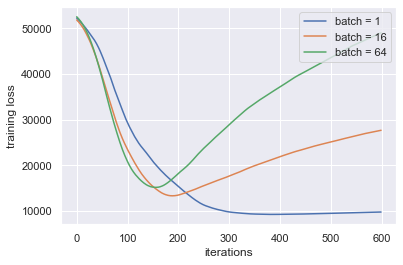

In [52]:
plt.figure()
plt.plot(slr_classifier_1.f_history_,label="batch = 1")
plt.plot(slr_classifier_2.f_history_, label="batch = 16")
#plt.plot(slr_classifier_3.f_history_, label="batch = 32")
plt.plot(slr_classifier_4.f_history_, label="batch = 64")

lines = plt.gca().get_lines()
include = [0,1,2]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.ylabel('training loss')
plt.xlabel('iterations')
plt.show()

- Normally, when a batch size is big enough, we get a stable estimate of what the gradient of the full data would be. A big batch size reduces computational cost as well.
- Normally a small batch size yields a noisy less accurate estimate of the gradient. But in our case, these noisy gradients helped escape the local minima (at iteration ~150).

### Learning Rate

In [30]:
#train classifier with learning rate = 1e-4
slr_classifier_1 = StochasticLogisticRegression(lr=1e-4, max_iter=400)
slr_classifier_1.fit(X_train, y_train)

In [32]:
#train classifier with learning rate = 1e-3
slr_classifier_2 = StochasticLogisticRegression(lr=1e-3, max_iter=400)
slr_classifier_2.fit(X_train, y_train)

In [33]:
#train classifier with learning rate = 0.01
slr_classifier_3 = StochasticLogisticRegression(lr=1e-2, max_iter=400)
slr_classifier_3.fit(X_train, y_train)

In [34]:
#train classifier with learning rate = 0.1
slr_classifier_4 = StochasticLogisticRegression(lr=1e-1, max_iter=400)
slr_classifier_4.fit(X_train, y_train)

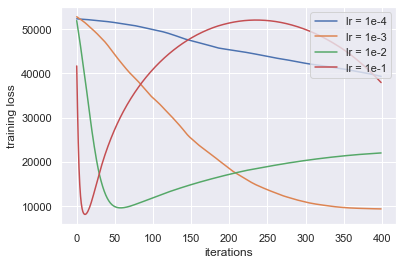

In [35]:
plt.figure()
plt.plot(slr_classifier_1.f_history_,label="lr = 1e-4")
plt.plot(slr_classifier_2.f_history_,label="lr = 1e-3")
plt.plot(slr_classifier_3.f_history_, label="lr = 1e-2")
plt.plot(slr_classifier_4.f_history_, label="lr = 1e-1")

lines = plt.gca().get_lines()
include = [0,1,2,3]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.ylabel('training loss')
plt.xlabel('iterations')
plt.show()

The learning rate controls how the parameters are updated at each iteration after computing the gradient.
In other words the learning rates controls how the model is adapted to the problem.
- If the learning rate is too small (lr = 1e-4), the changes of the parameters values at each update is too small. Hence, to converge to the optimal solution we need many iterations (Here 400 are not suffiscient, the training is visibly still decreasing for lr = 1e-4)
- If the learning rate is too large (lr = 0.1), the changes of the parameters values are too important. As a result, the model converges to a suboptimal solution very quickly (after 20 iterations) and then the training loss increases. Same thing for a lr=1e-2.
- A learning rate equal to 1e-3 seems to be a good choice as the training loss is slowly and consistently decreasing towards an optimal solution.

## Gamma

In [26]:
#train classifier with gamma = 0.1
slr_classifier_1 = StochasticLogisticRegression(gamma=0.1, max_iter=400)
slr_classifier_1.fit(X_train, y_train)

In [27]:
#train classifier with gamma = 0.5
slr_classifier_2 = StochasticLogisticRegression(gamma=0.5, max_iter=400)
slr_classifier_2.fit(X_train, y_train)

In [28]:
#train classifier with gamma = 0.9
slr_classifier_3 = StochasticLogisticRegression(gamma=0.9, max_iter=400)
slr_classifier_3.fit(X_train, y_train)

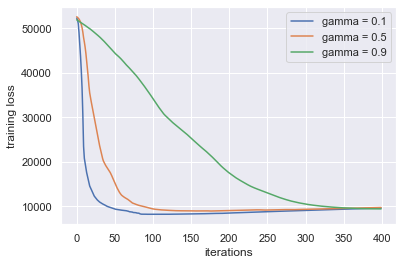

In [29]:
plt.figure()
plt.plot(slr_classifier_1.f_history_,label="gamma = 0.1")
plt.plot(slr_classifier_2.f_history_, label="gamma = 0.5")
plt.plot(slr_classifier_3.f_history_, label="gamma = 0.9")

lines = plt.gca().get_lines()
include = [0,1,2]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)

plt.ylabel('training loss')
plt.xlabel('iterations')
plt.show()

Here a value of 0.9 for gamma seems to be good because the training loss is decreasing slowly to an optimal solution.
For smaller values of betas (0.5 and 0.1 for example) the training loss deceases very quickly and converges to a sub-optimal solution.